In [19]:
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf #deep learning modeling
from tensorflow.keras.layers import Flatten, Conv2D, MaxPool2D, BatchNormalization, Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from google.colab import drive




MessageError: Error: credential propagation was unsuccessful

In [2]:
dataset, dataset_info = tfds.load('malaria',with_info=True,shuffle_files=True)
# split=['train[:80%]','train[80%:90%]','train[90%:]'],

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.FLG1O6_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:

TRAIN_RATIO=0.8
VAL_RATIO=0.1
TEST_RATIO=0.1
def split(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  DATA_SIZE=len(dataset)
  train_size=int(TRAIN_RATIO*DATA_SIZE)
  train_ds=dataset.take(train_size)
  print(train_size , train_ds)
  val_test_ds=dataset.skip(int(TRAIN_RATIO*DATA_SIZE))
  val_ds=val_test_ds.take(int(VAL_RATIO*DATA_SIZE))
  test_ds=val_test_ds.skip(int(VAL_RATIO*DATA_SIZE))

  return train_ds,val_test_ds,val_ds,test_ds

ds=tf.data.Dataset.range(len(dataset))
train_ds,val_test_ds,val_ds,test_ds=split(dataset['train'],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)




22046 <_TakeDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [4]:
# train_ds=dataset[0]
# val_ds=dataset[1]
# test_ds=dataset[2]
print(len(train_ds))

print(len(val_ds))

print(len(test_ds))

22046
2755
2757


In [5]:
def get_labeled_str(label):
  if label==0:
    return("parasitized")
  else:
    return("uninfected")

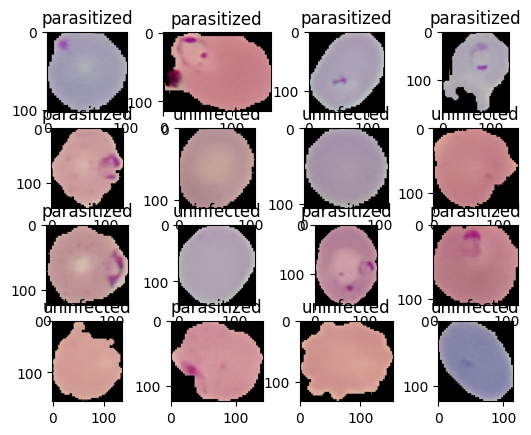

In [6]:
for i, sample in enumerate(train_ds.take(16)):
  ax=plt.subplot(4,4,i+1)
  plt.imshow(sample['image'])
  plt.title(get_labeled_str(sample['label']))


In [7]:
IM_SIZE=255
def resize_rescale(inputs):
  return((tf.image.resize(inputs['image'],((IM_SIZE,IM_SIZE)))/255),inputs['label'])

In [8]:
train_dataset=train_ds.map(resize_rescale)
train_dataset=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_ds.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_ds.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [9]:

malaria_model= tf.keras.Sequential([
    InputLayer(shape=(IM_SIZE,IM_SIZE,3)),
    Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Flatten(),
    Dense(100,activation='relu'),
    BatchNormalization(),
    Dense(10,activation='relu'),
    BatchNormalization(),
    Dense(1,activation='sigmoid'),

])


In [10]:
malaria_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 253, 253, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 253, 253, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 124, 124, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     6,150,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,153,097 (23.47 MB)

 Trainable params: 6,152,833 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

In [11]:
malaria_model.compile(optimizer=Adam(learning_rate=0.01),
                      loss=BinaryCrossentropy(),
                      metrics=[BinaryAccuracy()])

In [12]:
val_dataset = val_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

history=malaria_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 63s 76ms/step - binary_accuracy: 0.7863 - loss: 0.4381 - val_binary_accuracy: 0.9027 - val_loss: 0.3530
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - binary_accuracy: 0.9366 - loss: 0.1915 - val_binary_accuracy: 0.7093 - val_loss: 1.5586
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - binary_accuracy: 0.9464 - loss: 0.1689 - val_binary_accuracy: 0.9292 - val_loss: 0.2997
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 90s 72ms/step - binary_accuracy: 0.9493 - loss: 0.1590 - val_binary_accuracy: 0.9278 - val_loss: 0.1981
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - binary_accuracy: 0.9515 - loss: 0.1450 - val_binary_accuracy: 0.7735 - val_loss: 0.3910
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - binary_accuracy: 0.9564 - loss: 0.1341 - val_binary_accuracy: 0.8290 - val_loss: 0.6279
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - binary_accuracy: 0.9591 - loss: 0.1269 - val_binary_accuracy: 0.9492 - val_loss:

In [13]:
malaria_model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - binary_accuracy: 0.9480 - loss: 0.1689


[0.17799144983291626, 0.9441421627998352]

In [14]:
def infected_or_not(value):
  if value>0.5:
    return("0")
  else:
    return("1")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


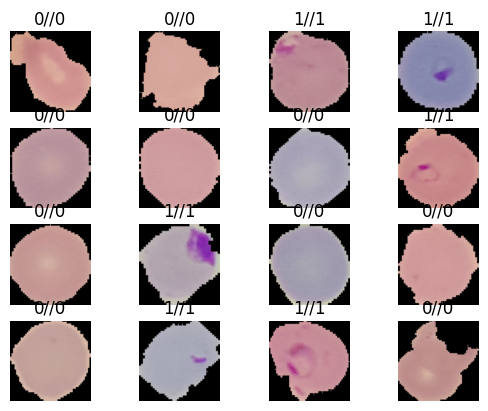

In [15]:

for image,label in test_dataset.take(1):
  for i in range(16):
    ax=plt.subplot(4,4,i+1)
    plt.imshow(image[i])
    plt.title(infected_or_not(label.numpy()[i])+"//"+infected_or_not(malaria_model.predict(image)[i]))
    plt.axis('off')


In [16]:
malaria_model.save("malaria_model.keras")

In [2]:
!git config --global user.name "tusharxtech"
!git config --global user.email "tspublic0100@gmail.com"


In [4]:
!git clone https://github.com/tusharxtech/m_model.git


Cloning into 'm_model'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [7]:
!cp --help


Usage: cp [OPTION]... [-T] SOURCE DEST
  or:  cp [OPTION]... SOURCE... DIRECTORY
  or:  cp [OPTION]... -t DIRECTORY SOURCE...
Copy SOURCE to DEST, or multiple SOURCE(s) to DIRECTORY.

Mandatory arguments to long options are mandatory for short options too.
  -a, --archive                same as -dR --preserve=all
      --attributes-only        don't copy the file data, just the attributes
      --backup[=CONTROL]       make a backup of each existing destination file
  -b                           like --backup but does not accept an argument
      --copy-contents          copy contents of special files when recursive
  -d                           same as --no-dereference --preserve=links
  -f, --force                  if an existing destination file cannot be
                                 opened, remove it and try again (this option
                                 is ignored when the -n option is also used)
  -i, --interactive            prompt before overwrite (overrides a previo